In [1]:
%matplotlib inline
import os
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from os import listdir
from os.path import isfile, join
import seaborn as sns
import pandas as pd
from sklearn import decomposition
from sklearn.manifold import TSNE
import matplotlib.pylab as plt
sns.set_style("whitegrid")


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#Load Data
source = "/Users/bobminnich/Documents/Columbia/Courses/DataVisualization/Edav-Text/source"
files = [f for f in listdir(source) if isfile(join(source, f))]
filenames_with_path = []
for i in files:
    filenames_with_path.append(source+ "/" + i)


In [3]:
# raw_texts = []
# for fn in filenames_with_path:
#     with open(fn) as f:
#         text = f.read()
#         text = text.replace('_', '')  # remove underscores (italics)
#         raw_texts.append(text)

In [4]:
#Read in Raw Texts
raw_texts = []
raw_texts_out = []


for fn in filenames_with_path:
    #split filename to get date
    check = fn.split("/")[-1].split("_")[0]
    with open(fn) as f:
        begin = 0
        raw_texts = []
        for line in f:
            #print line
            line.replace("000","")
            #if line is past the date, begin to read in information
            if begin == 1:
                #Append line if we have gone past initial date in header
                raw_texts.append((line))
            else:
                #Check to see if date is in header, if it has gone past the line begin to read in data
                if check in line.lower():
                    raw_texts.append("")
                    begin = 1
    raw_texts_out.append(' '.join(raw_texts))


In [5]:
#Set up vectorization and remove English Stop Words
vectorizer = CountVectorizer(input='content', stop_words="english")

In [6]:
#Fit data to vectorizer
dtm = vectorizer.fit_transform(raw_texts_out)

In [7]:
#Convert to matrix
vocab = np.array(vectorizer.get_feature_names())

In [9]:
#Convert to array
dtm = dtm.toarray()

In [11]:
#Convert to Data Frame
df = pd.DataFrame(dtm)

In [12]:
#Rename Columns to words
df.columns = vocab

In [13]:
#Read in presdident info
pres_df = pd.read_csv("PresidentInfo.csv")
a = list(pres_df.columns)
a[2] = "year"
a[0] = "name"

#Correct mismatched names
pres_df.columns = a
pres_df.name = pres_df.name.str.replace("George Bush","George H.W. Bush")
pres_df.name = pres_df.name.str.replace("Bill Clinton","William J. Clinton")
pres_df.name = pres_df.name.str.replace("George Bush","George H.W. Bush")
pres_df.name = pres_df.name.str.replace("William Howard Taft","William H. Taft")
pres_df.name = pres_df.name.str.replace("Warren G. Harding","Warren Harding")
pres_df.name = pres_df.name.str.replace("Franklin Roosevelt","Franklin D. Roosevelt")
pres_df.name = pres_df.name.str.replace("Richard M. Nixon","Richard Nixon")
pres_df.name = pres_df.name.str.replace("Gerald Ford","Gerald R. Ford")
pres_df.name = pres_df.name.str.replace("Martin Van Buren ","Martin van Buren")
pres_df.name = pres_df.name.str.replace("James K. Polk","James Polk")


#Read in table of contents information
toc = pd.read_csv("table_of_contents.txt", header=-1)
toc["file"] = files

#Update columns
toc.columns = ["name","speech","MD","year", "File"]
toc = toc.drop("speech",1)

#Merge both dataframes for output for group
finaldf = pd.merge(toc,pres_df ,how="left",on=["name"])
finaldf = finaldf[finaldf.File.duplicated() == False]
finaldf.to_csv("President_Info2.csv")

# Create Color Codes

In [15]:
#Compute statistics of ratings, median and quantiles
stats_df = finaldf[finaldf.name.duplicated() == False]
stats_df.columns
ratings = stats_df["Rating points"]
ratings = ratings[np.isnan(ratings) == False]
median = np.percentile(ratings,50)
per_75 = np.percentile(ratings,75)
per_25 = np.percentile(ratings,25)



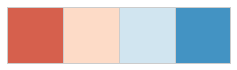

In [16]:
#Set colors for ratings
ratings_colors = []
cols = sns.diverging_palette(260, 20, n=4)
            
cols = sns.color_palette("RdBu",(4))
sns.palplot(cols)




In [92]:
#Set boundaries to determin if in Lower 25 Mid 25-50 50 to 75 and 75+


sns.light_palette("red")
finaldf["RatingGroup"] = 0
for i in finaldf.index:
    if finaldf["Rating points"][i] <= per_25:
        #ratings_colors.append(cols[0])
        finaldf["RatingGroup"][i] = 0
    elif finaldf["Rating points"][i] <= median:
        #ratings_colors.append(cols[1])
        finaldf["RatingGroup"][i] = 1
    elif finaldf["Rating points"][i] <= per_75:
        #ratings_colors.append(cols[2])
        finaldf["RatingGroup"][i] = 2
    elif finaldf["Rating points"][i] > per_75:
        #ratings_colors.append(cols[3])
        finaldf["RatingGroup"][i] = 3
    else:
        #ratings_colors.append([(0,0,0)])
        finaldf["RatingGroup"][i] = 4



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

# Create Dimensions

In [18]:
#Create Random Forests that create 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators= 500, n_jobs=-1)


In [19]:
#Fit random forests
rf.fit(df,toc.name)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
#Define Feature importance
a = rf.feature_importances_

In [21]:
#Sort Feature importance
features = np.argsort(a)[::-1]


[18593 13489 13303 17841 22826 23284 11134 20620  2274 12943 16662   416
  2882 23711 18594  7782  6091 24078 10196  8364   424 13978 14750 21894
  5578]
Feature ranking:


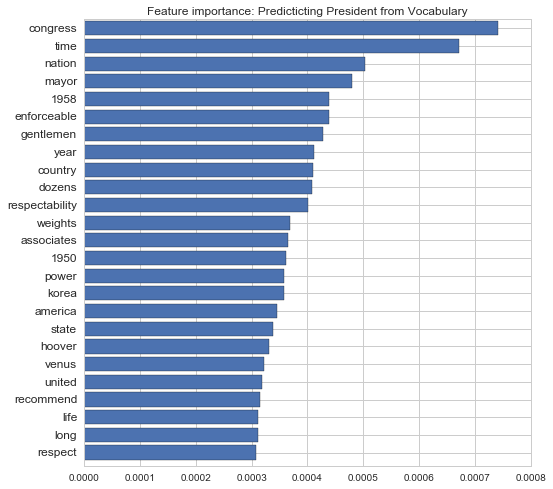

In [89]:
#Set figure size and parameters
fig = plt.figure()
fig.set_size_inches(8, 8)
ax1 = fig.add_subplot(1,1,1)
#ax2 = fig.add_subplot(1,2,2)


#Define importance and sort
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][0:25]
indices = indices[::-1]
# Print the feature ranking
X = df
# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

ax1.barh(range(len(indices)),importances[indices], align="center", color = current_palette[0])
plt.yticks(range(len(indices)), df.columns[indices], fontsize = 12)

plt.ylim([-0.75,24.5])


#ax2.barh(range(len(indices))[0:24],importances[indices[0:24]],color="r", align="center")
#plt.yticks(range(len(indices))[0:24], df.columns[indices][0:24])


plt.title("Feature importance: Predicticting President from Vocabulary")


#plt.ylim([-1, X.shape[1]])
plt.savefig("figs/ImportancePlot.png")


### TSNE

In [24]:
#Set up TSNE for 2 and 3 dimensions
tsne = TSNE()
tsnew = tsne.fit_transform(df)
tsne = TSNE(n_components=3)
tsnew3D = tsne.fit_transform(df)

### PCA

In [25]:
#Set up PCA for 2 and 3 dimensions
pca = decomposition.PCA(n_components=2)
new_pca = pca.fit_transform(df)
pca = decomposition.PCA(n_components=3)
new_pca3D = pca.fit_transform(df)



### MDS

In [26]:
from sklearn.manifold import MDS

In [27]:
#Set up MDS for 2 and 3 dimensions
mds = MDS(n_components=2, dissimilarity="euclidean")

In [28]:
mdsnew = mds.fit_transform(df)
mds = MDS(n_components=3, dissimilarity="euclidean")
mdsnew3D = mds.fit_transform(df)



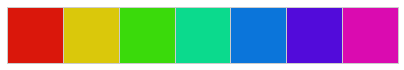

In [93]:
#Set colors for Poltical Party
from matplotlib.colors import hex2color, rgb2hex
parties = np.unique(finaldf["Political Party"])
sns.palplot(sns.hls_palette(len(parties), l=.45, s=.9))


cols = sns.color_palette("Set3", len(parties))
cols = sns.hls_palette(len(parties), l=.45, s=.9)


col_dict = dict(zip(parties,cols))
col_list = []
for i in finaldf.index:
    col_list.append(rgb2hex(col_dict[finaldf["Political Party"][i]]))

hex_list = []
for i in cols:
    hex_list.append(rgb2hex(i))

220


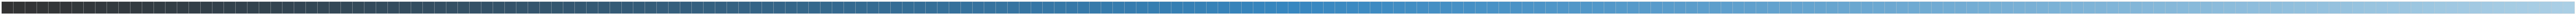

In [94]:
#Set colors for years
years = np.unique(finaldf.year_x)
#cols = sns.color_palette("Spectral", len(years) )
padding = 200
cols2 = sns.color_palette("Blues_d",(len(years)+padding))[0:len(years)]
cols = sns.color_palette("Blues_d",(len(years)))


#Set colors for the legend
cols_plot = cols


#cols_plot = sns.color_palette("Spectral", 10)
col_dict2 = dict(zip(years,cols))
#col_list = []


sns.palplot(cols_plot)

#sns.choose_colorbrewer_palette(10)


#Create color list in Hex for R to understand
out_color = []
for i in finaldf.year_x:
    out_color.append(rgb2hex(col_dict2[i]))

In [96]:
#Combine multiple dataframes for R for 3D plotting, PCA, MDS, TSNE, Labels and Colors
df1 = pd.DataFrame(mdsnew3D)
df2 = pd.DataFrame(new_pca3D)
df3 = pd.DataFrame(tsnew3D)
df_labels = pd.DataFrame(finaldf.name.reset_index(drop=True))
df_colors = pd.DataFrame(out_color)
df_labels_years = pd.DataFrame(col_list)
df5 = pd.concat([df1,df2,df3,df_labels,df_labels_years,df_colors],axis = 1)
print df5.shape
print df5.columns
df5.columns = ["MDS1","MDS2","MDS3","PCA1","PCA2","PCA3","TSN1","TSN2","TSN3","name","color","years"]

(224, 12)
Index([0, 1, 2, 0, 1, 2, 0, 1, 2, u'name', 0, 0], dtype='object')


In [97]:
#Save to file
df5.to_csv("3D_Plotting.csv")

In [98]:
#Define colors of parties
parties = np.unique(finaldf["Political Party"])
cols = sns.color_palette("Set3", len(parties))
cols = sns.hls_palette(len(parties), l=.45, s=.9)
col_dict = dict(zip(parties,cols))
col_list = []
for i in finaldf.index:
    col_list.append(rgb2hex(col_dict[finaldf["Political Party"][i]]))

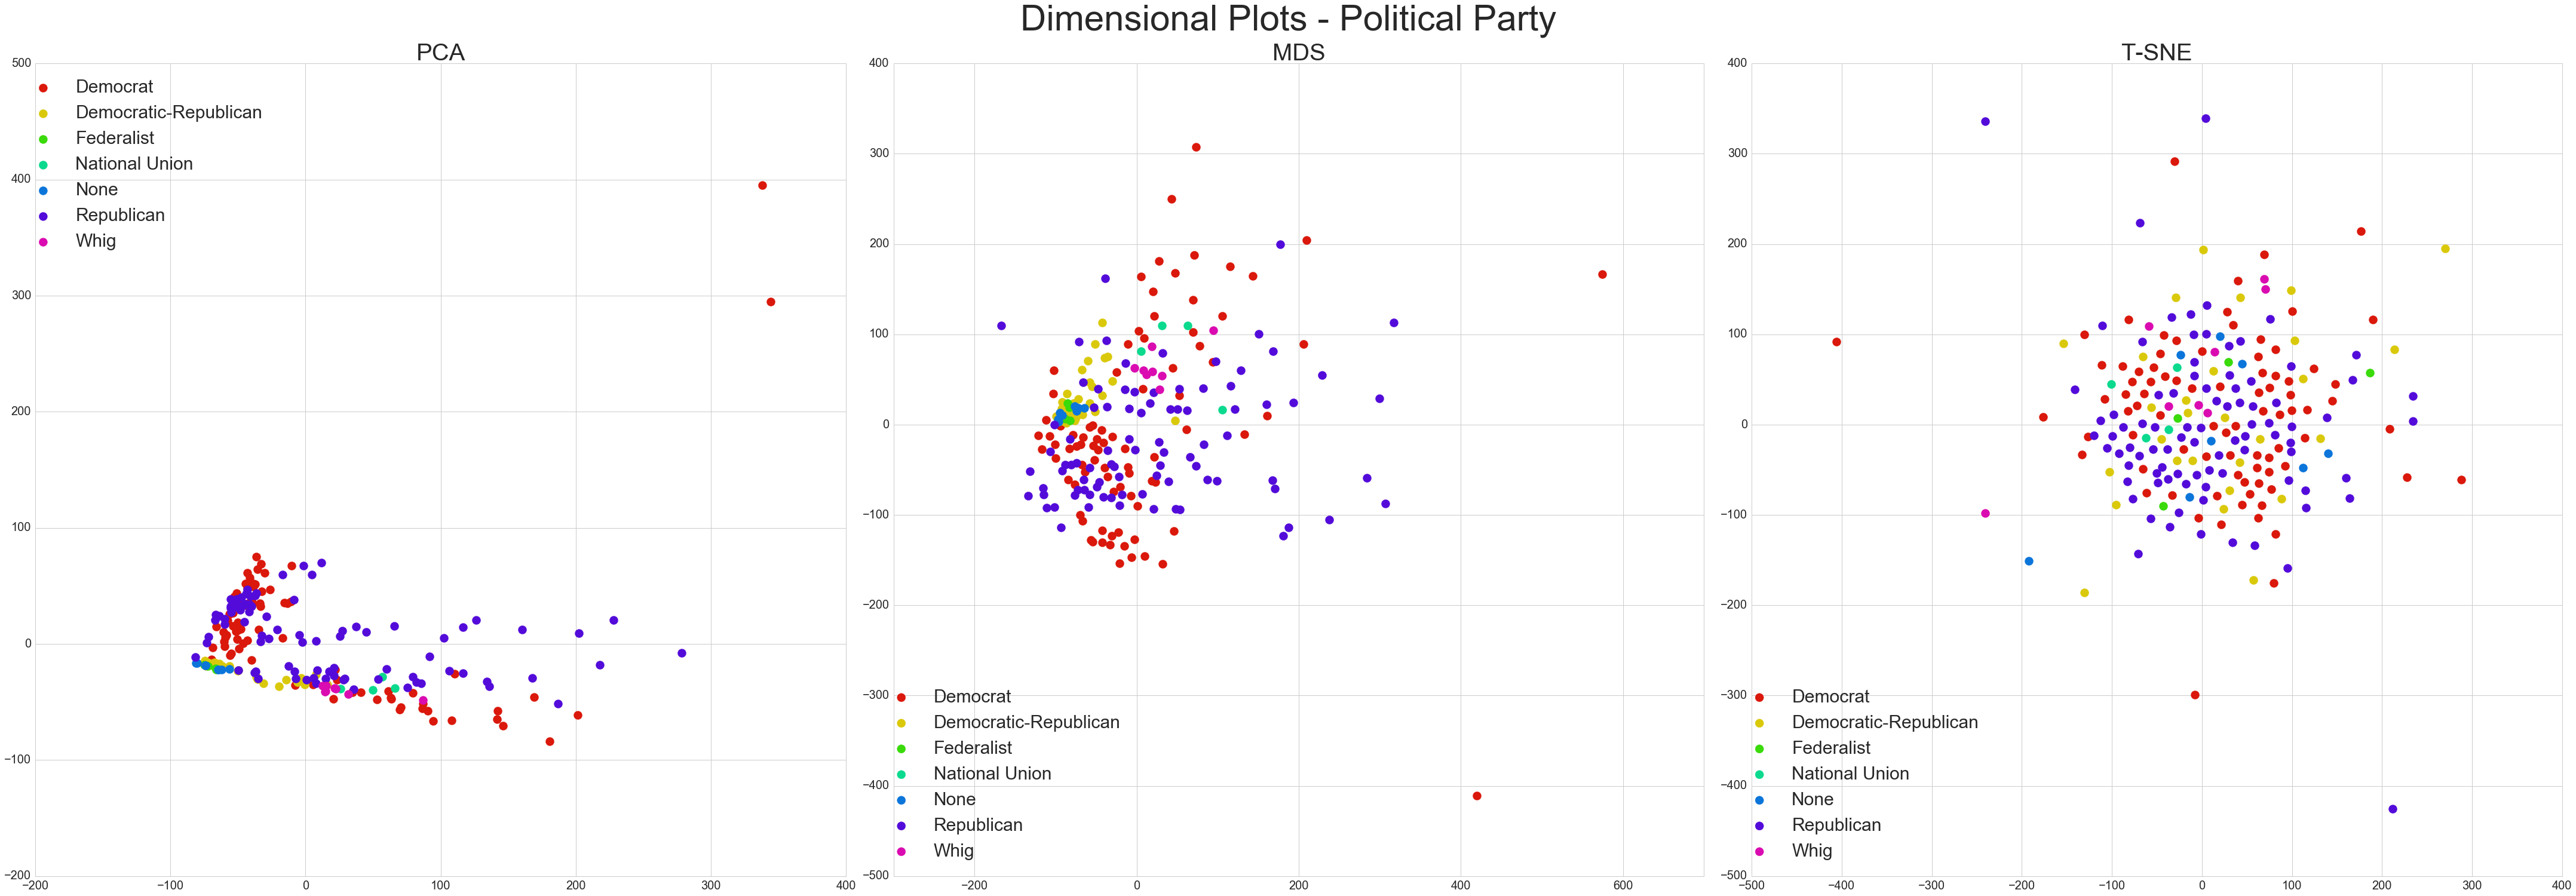

In [124]:
fig = plt.figure()
fig.set_size_inches(60, 20)
#ax2 = fig.add_subplot(3,1,1)
ax1 = fig.add_subplot(1,3,1)
xticksize = 20

#PCA

size = 200


title_size = 40

x = new_pca[:,0]
y = new_pca[:,1]
#plt.scatter(x,y)
#plt.text(x,y,finaldf.Namea)


plot_df = finaldf
plot_df["x"] = x
plot_df["y"] = y

for i in parties:
    intdf = plot_df[plot_df["Political Party"]==i]
    ax1.scatter(intdf.x,intdf.y,color = col_dict[i], s = size )
plt.title("PCA", fontsize = title_size)
#plt.legend(parties, bbox_to_anchor=(1.38, 1), fontsize = 12)
plt.xticks(fontsize = xticksize)
plt.yticks(fontsize = xticksize)
plt.legend(parties, bbox_to_anchor=(0.3, 1), fontsize = 30)





#MDS
ax2 = fig.add_subplot(1,3,2)


x = mdsnew[:,0]
y = mdsnew[:,1]
plot_df = finaldf
plot_df["x"] = x
plot_df["y"] = y

for i in parties:
    intdf = plot_df[plot_df["Political Party"]==i]
    ax2.scatter(intdf.x,intdf.y,color = col_dict[i], s = size )

#plt.legend(parties, bbox_to_anchor=(1.38, 1), fontsize = 12)

plt.title("MDS", fontsize = title_size)
plt.xticks(fontsize = xticksize)
plt.yticks(fontsize = xticksize)
plt.legend(parties, bbox_to_anchor=(0.3, 0.25), fontsize = 30)





#TSNE
ax3 = fig.add_subplot(1,3,3)




x = tsnew[:,0]
y = tsnew[:,1]


plot_df = finaldf
plot_df["x"] = x
plot_df["y"] = y

for i in parties:
    intdf = plot_df[plot_df["Political Party"]==i]
    ax3.scatter(intdf.x,intdf.y,color = col_dict[i], s = size )
plt.title("T-SNE", fontsize = title_size)
plt.legend(parties, bbox_to_anchor=(0.3, 0.25), fontsize = 30)
plt.xticks(fontsize = xticksize)
plt.yticks(fontsize = xticksize)
plt.tight_layout()
fig.suptitle("Dimensional Plots - Political Party", fontsize = 60,y = 1,verticalalignment = "bottom" )
fig.tight_layout()
fig.savefig("figs/Dimension_Plots_Party.png")



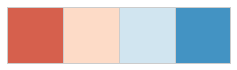

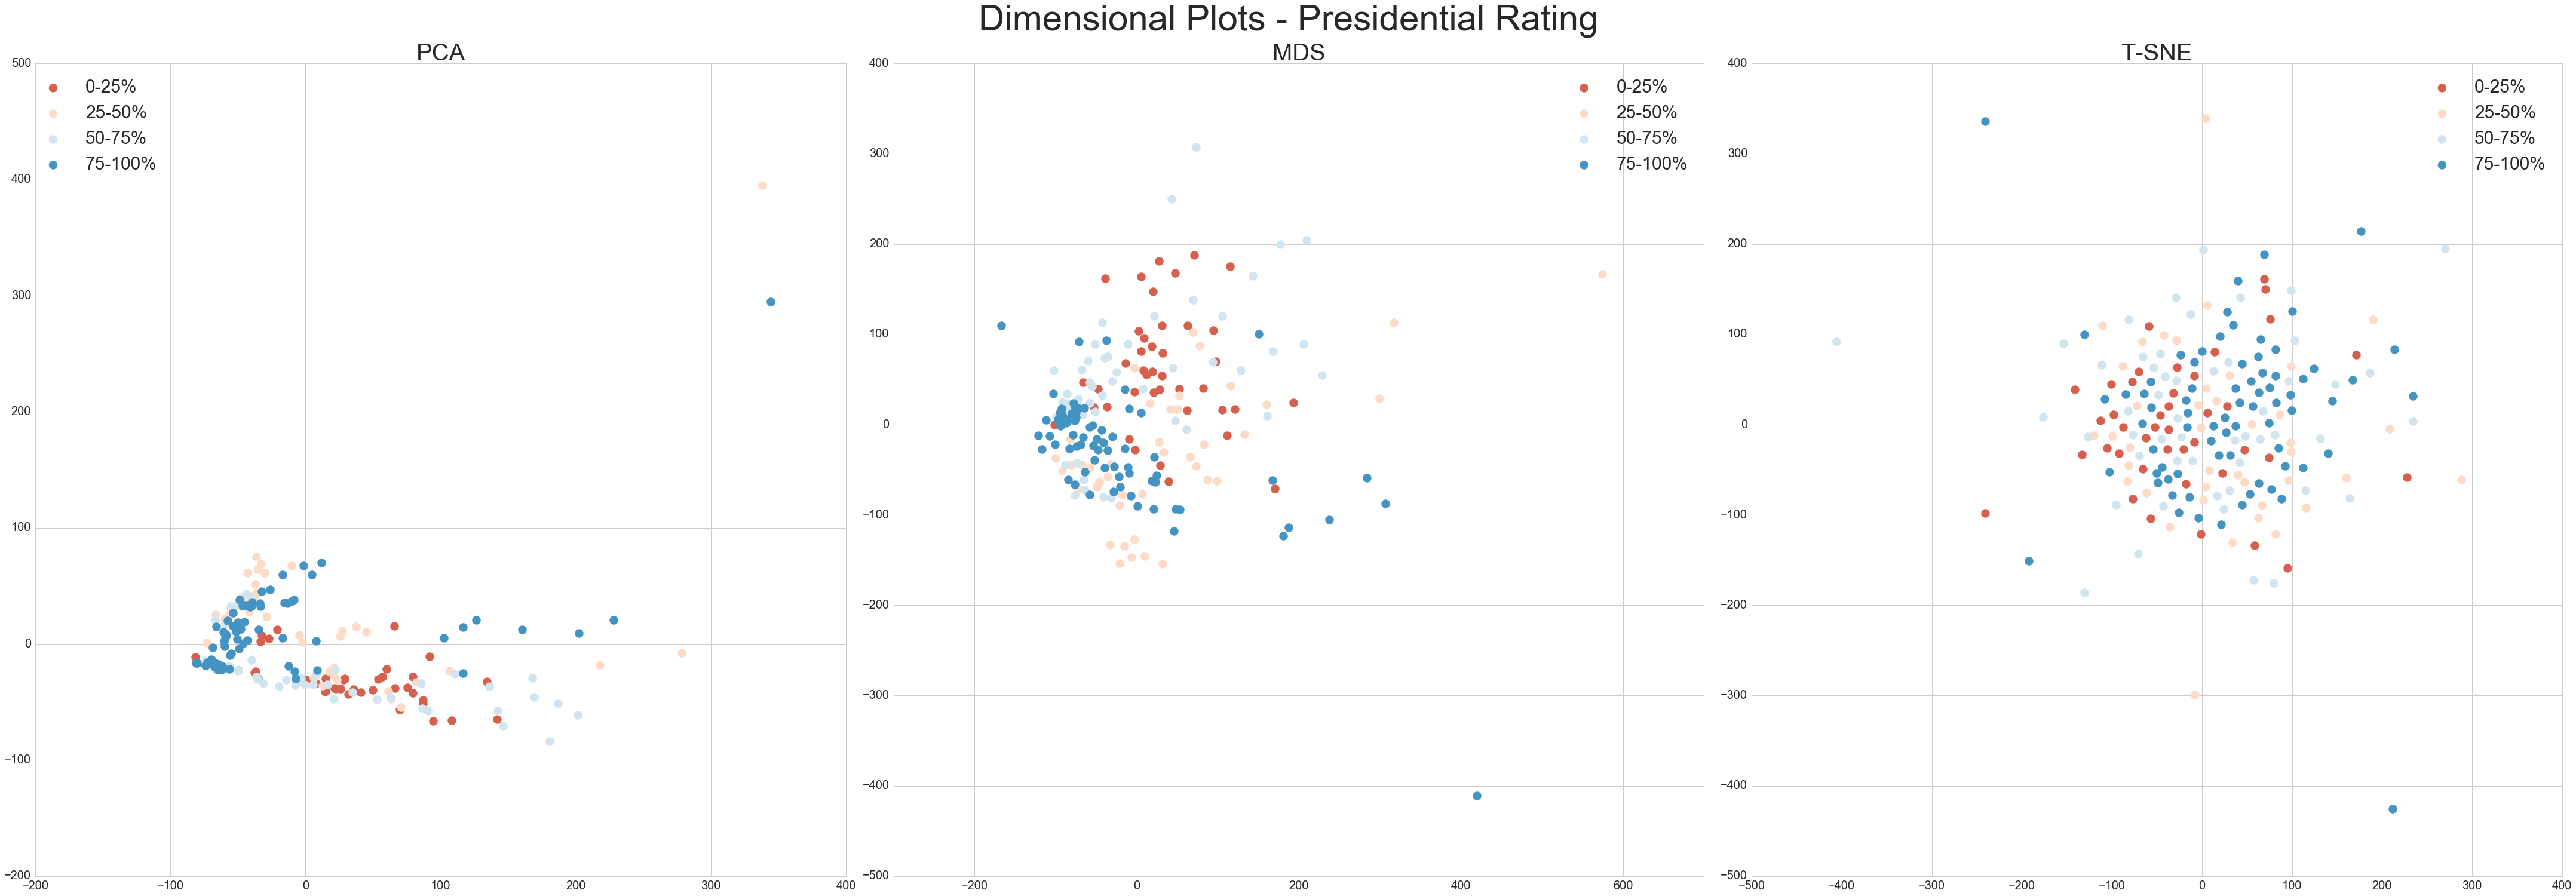

In [125]:
#Plot Ratings


ratings_colors = []
cols = sns.diverging_palette(260, 20, n=4)
            
cols = sns.color_palette("RdBu",(4))
sns.palplot(cols)


fig = plt.figure()
fig.set_size_inches(60, 20)
#ax2 = fig.add_subplot(3,1,1)
ax1 = fig.add_subplot(1,3,1)
xticksize = 20



size = 200
title_size = 40

#PCA
x = new_pca[:,0]
y = new_pca[:,1]




plot_df = finaldf
plot_df["x"] = x
plot_df["y"] = y


#Plot differnt colors based on ratings
for i in range(4):
    intdf = plot_df[plot_df["RatingGroup"]==i]
    plt.scatter(intdf.x,intdf.y,color = cols[i], s = size )

plt.title("PCA", fontsize = title_size)
#plt.legend(parties, bbox_to_anchor=(1.38, 1), fontsize = 12)
plt.xticks(fontsize = xticksize)
plt.yticks(fontsize = xticksize)
plt.legend(["0-25%","25-50%","50-75%","75-100%"], bbox_to_anchor=(.17, 1), fontsize = 30)



#MDS

ax2 = fig.add_subplot(1,3,2)


x = mdsnew[:,0]
y = mdsnew[:,1]
plot_df = finaldf
plot_df["x"] = x
plot_df["y"] = y

for i in range(4):
    intdf = plot_df[plot_df["RatingGroup"]==i]
    plt.scatter(intdf.x,intdf.y,color = cols[i], s = size )


#plt.legend(parties, bbox_to_anchor=(1.38, 1), fontsize = 12)

plt.title("MDS", fontsize = title_size)
plt.xticks(fontsize = xticksize)
plt.yticks(fontsize = xticksize)
plt.legend(["0-25%","25-50%","50-75%","75-100%"], bbox_to_anchor=(1, 1), fontsize = 30)




#TSNE
ax3 = fig.add_subplot(1,3,3)




x = tsnew[:,0]
y = tsnew[:,1]


plot_df = finaldf
plot_df["x"] = x
plot_df["y"] = y

for i in range(4):
    intdf = plot_df[plot_df["RatingGroup"]==i]
    plt.scatter(intdf.x,intdf.y,color = cols[i], s = size )

plt.title("T-SNE", fontsize = title_size)

#Change Tick Size
plt.xticks(fontsize = xticksize)
plt.yticks(fontsize = xticksize)
fig.suptitle("Dimensional Plots - Presidential Rating", fontsize = 60,y = 1,verticalalignment = "bottom" )
plt.tight_layout()


fig.tight_layout()

fig.savefig("figs/Dimension_Plots_Rating.png")


plt.legend(["0-25%","25-50%","50-75%","75-100%"], bbox_to_anchor=(1, 1), fontsize = 30)
plt.savefig("test.png")


##### 

In [127]:
#Set Colors
years = np.unique(finaldf.year_x)
cols = sns.color_palette("Spectral", len(years))
cols_plot = sns.color_palette("Spectral", 10)
col_dict = dict(zip(years,cols))
col_list = []

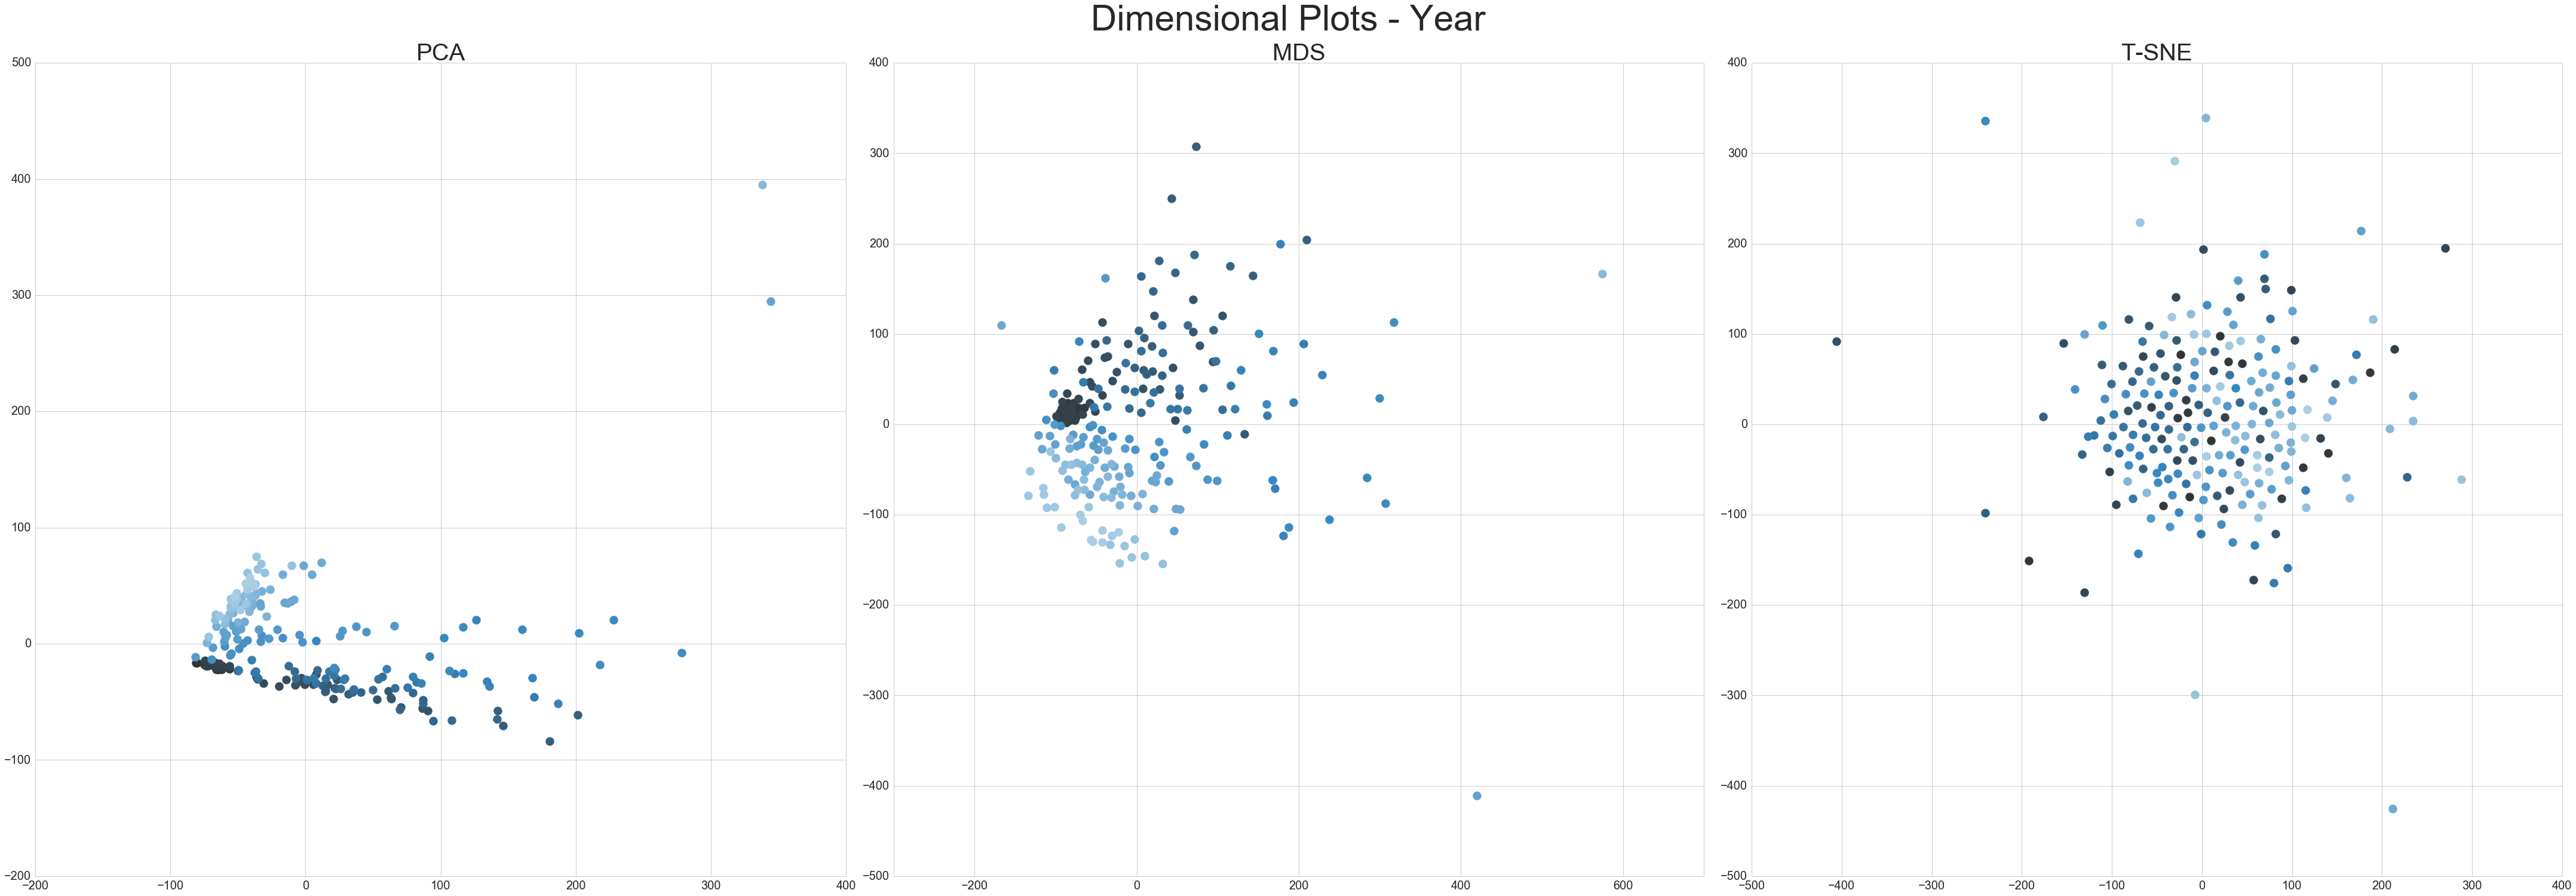

In [133]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig = plt.figure()
fig.set_size_inches(60, 20)
#ax2 = fig.add_subplot(3,1,1)
ax1 = fig.add_subplot(1,3,1)
xticksize = 20



size = 200


title_size = 40

#Plot PCA

x = new_pca[:,0]
y = new_pca[:,1]
#plt.scatter(x,y)
#plt.text(x,y,finaldf.Namea)


plot_df = finaldf
plot_df["x"] = x
plot_df["y"] = y

for i in years:

    intdf = plot_df[plot_df.year_x==i]

    ax1.scatter(intdf.x,intdf.y,color = col_dict2[i], s = size )
plt.title("PCA", fontsize = title_size)
#plt.legend(parties, bbox_to_anchor=(1.38, 1), fontsize = 12)
plt.xticks(fontsize = xticksize)
plt.yticks(fontsize = xticksize)





#Plot MDS
ax2 = fig.add_subplot(1,3,2)


x = mdsnew[:,0]
y = mdsnew[:,1]
plot_df = finaldf
plot_df["x"] = x
plot_df["y"] = y

for i in years:
    intdf = plot_df[plot_df.year_x==i]
    ax2.scatter(intdf.x,intdf.y,color = col_dict2[i], s = size )


plt.title("MDS", fontsize = title_size)
plt.xticks(fontsize = xticksize)
plt.yticks(fontsize = xticksize)


ax3 = fig.add_subplot(1,3,3)


#Plot TSNE
x = tsnew[:,0]
y = tsnew[:,1]


plot_df = finaldf
plot_df["x"] = x
plot_df["y"] = y

for i in years:
    intdf = plot_df[plot_df.year_x==i]
    ax3.scatter(intdf.x,intdf.y,color = col_dict2[i], s = size )


plt.title("T-SNE", fontsize = title_size)


#Plot Xticks and adjust sizes 
plt.xticks(fontsize = xticksize)
plt.yticks(fontsize = xticksize)
fig.suptitle("Dimensional Plots - Year", fontsize = 60,y = 1,verticalalignment = "bottom" )

plt.tight_layout()



fig.savefig("figs/Dimension_Plots_Years.png")





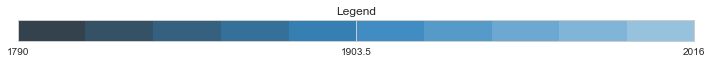

In [131]:
#Create legend 
cols_plot = sns.color_palette("Blues_d",10)
sns.palplot(cols_plot)

plt.title("Legend")
plt.xticks([-0.5,4.5,9.5],[years.min(),np.median(years),years.max(),])
plt.tight_layout()
plt.savefig("figs/Dimension_Plots_Years_Legend.png")

In [161]:
from sklearn.ensemble import RandomForestRegressor
#Set random forests to do classification on years
rf = RandomForestClassifier(n_estimators= 500, n_jobs=-1,random_state=3)
rf.fit(df,toc.year)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

[19490 11559  9900 16050  2882  9821 20628  7592 13978  6608 20620   416
 12943  8364 24078   424 10342 23711 14875 21894 10196 18594  7782 14750
  5578]
Feature ranking:


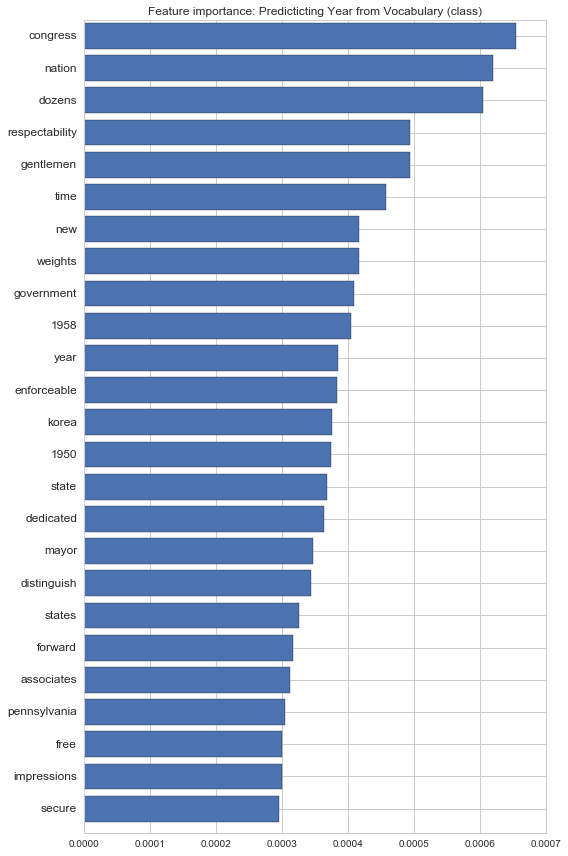

In [162]:
fig = plt.figure()
fig.set_size_inches(8, 12)
ax1 = fig.add_subplot(1,1,1)
#ax2 = fig.add_subplot(1,2,2)


#Plot importance features of predicting year

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][0:25]
indices = indices[::-1]
print indices
# Print the feature ranking
print("Feature ranking:")
X = df




# Plot the feature importances of the forest

ax1.barh(range(len(indices)),importances[indices], align="center", color = current_palette[0])
plt.yticks(range(len(indices)), df.columns[indices], fontsize = 12)

plt.ylim([-0.75,24.5])

#Titiel

plt.title("Feature importance: Predicticting Year from Vocabulary (class)")
plt.tight_layout()

#plt.ylim([-1, X.shape[1]])
plt.savefig("figs/ImportancePlot_Years_50.png")